### импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import re
import tqdm
import yaml


from pymystem3 import Mystem
from razdel import tokenize, sentenize
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

### загрузка стоп-слов (с сайта https://snipp.ru/seo/stop-ru-words)

In [2]:
# load stopwords
with open('ru_stopwords.yaml', 'r') as f:
    ru_stopwords = yaml.safe_load(f)

### Загрузка датасета

# 16

In [16]:
age = 61
gender = 2

In [17]:
dataset_path = f'datasets/{age}_{gender}_0_150.csv'
dataset = pd.read_csv(dataset_path, delimiter='\t')
dataset.head()

,text,gender,age,numwords,userid,year
0,Спасибо Мария за чудесный концерт! Благодарим ...,2,61,9,103610,2019
1,Сохрани Господь,2,61,2,103610,2019
2,Органной концерт прошёл великолепно! Спасибо М...,2,61,22,103610,2019
3,С Рождением!!! Благословений!!!,2,61,3,103610,2019
4,Дендробиум раскрылся. Цвет не получился.,2,61,5,10616500,2020


In [18]:
print(len(dataset))

319734


In [19]:
dataset_short = dataset if len(dataset) <= 500000 else dataset.sample(500000)
dataset_short.replace('þ<br />þ', '\n ', regex=True, inplace=True)
dataset_short.head()

,text,gender,age,numwords,userid,year
0,Спасибо Мария за чудесный концерт! Благодарим ...,2,61,9,103610,2019
1,Сохрани Господь,2,61,2,103610,2019
2,Органной концерт прошёл великолепно! Спасибо М...,2,61,22,103610,2019
3,С Рождением!!! Благословений!!!,2,61,3,103610,2019
4,Дендробиум раскрылся. Цвет не получился.,2,61,5,10616500,2020


In [26]:
for i in range(123):
    print(i, dataset_short.iloc[i].text)

0 Спасибо Мария за чудесный концерт! Благодарим вас дорогие Приморчане!
1 Сохрани Господь
2 Органной концерт прошёл великолепно! Спасибо Марии, Ирине и Виталии! Спасибо Приморчанам!!! И отдельно Ульяне за сопровождение и фото! Ждём в 16 февраля вновь!!!
3 С Рождением!!! Благословений!!!
4 Дендробиум раскрылся. Цвет не получился.
5 Мини... я бы сказал микро конопатик!
6 А вот это сьедобное?
7 Sunset раскрылся плностью
8 Возможно последний стрепсик
9 Спаниель Тиффани( для близких друзей Дуся) с тапочком.
10 Благодаря ценным советам Татьяны П. Чрезмерные усердия были направлены в правильное русло!)))
11 Полтора месяца наблюдал за... И вот НЕОЖИДАННО!!!!))))) распустилась каттлейка!
12 Стрепсики подумали и решили еще поцвести разик!
13 Снега нападало!!!
14 Народ веселится, как позволяет фантазия!)))
15 Обеденный зал , где Генрих6 откушать соизволял.
16 Зима закончилась! Всю ночь- +2!
17 Ну а как новый год без снега?
18 А на этикетке было написано, что Al fresco!!! Обидно! Но и такому очень

In [8]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc), deacc=True) if word not in ru_stopwords] for doc in texts]

def preprocess_fast(texts, step=10):
    i = 0
    texts_without_stopwords = [" ".join(txt) for txt in remove_stopwords(data)]
    lol = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]
    txtpart = lol(texts_without_stopwords, step)
    res = []
    for txtp in tqdm.tqdm(txtpart):
        alltexts = ' '.join([txt + ' br ' for txt in txtp])

        words = stem.lemmatize(alltexts)
        doc = []
        for txt in words:
            if txt != '\n' and txt.strip() != '':
                if txt == 'br':
                    res.append(doc)
                    doc = []
                else:
                    doc.append(txt)
    return res

def preprocess(text):
    tokens = stem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in ru_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    # text = " ".join(tokens)
    
    return token

In [10]:
stem = Mystem()
data = dataset_short['text'].tolist()
preprocessed_fast_data = preprocess_fast(data, 10000)

100%|██████████| 50/50 [02:58<00:00,  3.57s/it]


In [14]:
# Create Dictionary
id2word = corpora.Dictionary(preprocessed_fast_data)
# Create Corpus
texts = preprocessed_fast_data
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])


[[(0, 1), (1, 1)]]


In [15]:
# Build LDA model
for num_topics in range(6, 20):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=2000,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
    for i in lda_model.print_topics():
        print(i)
    with open(f'topics_1_500000_{age}_{gender}.yaml', 'w') as file:
        yaml.dump(dict(lda_model.print_topics()), file)
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    pyLDAvis.save_html(vis, f'topics_{num_topics}_{50000}_{age}_{gender}.html')

(0, '0.045*"http" + 0.041*"com" + 0.040*"https" + 0.038*"ru" + 0.027*"www" + 0.020*"_" + 0.016*"vk" + 0.014*"id" + 0.012*"youtube" + 0.012*"amp"')
(1, '0.008*"цена" + 0.007*"нужный" + 0.007*"помогать" + 0.007*"писать" + 0.006*"тело" + 0.005*"первыя" + 0.005*"работать" + 0.005*"внимание" + 0.005*"купить" + 0.004*"просить"')
(2, '0.015*"любить" + 0.011*"фильм" + 0.011*"песня" + 0.007*"небо" + 0.006*"онлаин" + 0.006*"музыка" + 0.006*"читать" + 0.005*"ночь" + 0.004*"солнце" + 0.004*"сон"')
(3, '0.010*"друг" + 0.009*"новый" + 0.008*"день" + 0.007*"хороший" + 0.005*"видео" + 0.005*"смотреть" + 0.005*"фото" + 0.005*"первый" + 0.005*"ждать" + 0.005*"группа"')
(4, '0.008*"человек" + 0.006*"любовь" + 0.006*"украина" + 0.006*"каждый" + 0.006*"какой" + 0.005*"путин" + 0.005*"воин" + 0.005*"знать" + 0.004*"который" + 0.004*"сеичас"')
(5, '0.006*"получать" + 0.006*"вопрос" + 0.006*"проект" + 0.005*"область" + 0.005*"новость" + 0.005*"раион" + 0.005*"рублея" + 0.005*"программа" + 0.005*"сша" + 0.005*

c:\Users\Димас\venvs\main_venv\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


(0, '0.050*"http" + 0.045*"com" + 0.044*"https" + 0.041*"ru" + 0.029*"www" + 0.022*"_" + 0.018*"vk" + 0.015*"id" + 0.014*"youtube" + 0.014*"amp"')
(1, '0.007*"цена" + 0.006*"получать" + 0.006*"нужный" + 0.006*"помогать" + 0.006*"писать" + 0.006*"проект" + 0.006*"работа" + 0.005*"москва" + 0.005*"работать" + 0.005*"рублея"')
(2, '0.019*"видео" + 0.014*"фильм" + 0.013*"песня" + 0.008*"онлаин" + 0.007*"музыка" + 0.005*"запись" + 0.005*"автор" + 0.005*"добавлять" + 0.004*"прямой" + 0.004*"питер"')
(3, '0.011*"друг" + 0.010*"новый" + 0.009*"день" + 0.008*"хороший" + 0.006*"смотреть" + 0.006*"фото" + 0.005*"первый" + 0.005*"ждать" + 0.005*"группа" + 0.005*"ребенок"')
(4, '0.008*"человек" + 0.007*"любовь" + 0.006*"каждый" + 0.006*"какой" + 0.005*"воин" + 0.005*"знать" + 0.005*"людей" + 0.005*"думать" + 0.005*"который" + 0.004*"мир"')
(5, '0.009*"украина" + 0.008*"путин" + 0.008*"страна" + 0.005*"область" + 0.005*"раион" + 0.005*"власть" + 0.005*"новость" + 0.005*"сша" + 0.005*"рф" + 0.004*"пр

c:\Users\Димас\venvs\main_venv\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


(0, '0.052*"http" + 0.047*"com" + 0.046*"https" + 0.043*"ru" + 0.031*"www" + 0.023*"_" + 0.019*"vk" + 0.016*"id" + 0.014*"youtube" + 0.014*"amp"')
(1, '0.009*"цена" + 0.008*"нужный" + 0.007*"писать" + 0.006*"тело" + 0.005*"купить" + 0.005*"решать" + 0.005*"размер" + 0.004*"качество" + 0.004*"ответ" + 0.004*"лето"')
(2, '0.018*"любить" + 0.013*"песня" + 0.007*"онлаин" + 0.007*"книга" + 0.007*"музыка" + 0.007*"моеи" + 0.007*"красивый" + 0.007*"читать" + 0.007*"самыя" + 0.006*"сказать"')
(3, '0.014*"друг" + 0.012*"новый" + 0.011*"день" + 0.010*"хороший" + 0.008*"видео" + 0.007*"фото" + 0.006*"первый" + 0.006*"ждать" + 0.006*"группа" + 0.006*"ребенок"')
(4, '0.010*"человек" + 0.009*"каждый" + 0.008*"любовь" + 0.007*"смотреть" + 0.007*"какой" + 0.007*"сеичас" + 0.006*"знать" + 0.006*"людей" + 0.006*"воин" + 0.006*"думать"')
(5, '0.009*"город" + 0.007*"получать" + 0.006*"вопрос" + 0.006*"москва" + 0.006*"проект" + 0.006*"работа" + 0.005*"область" + 0.005*"раион" + 0.005*"работать" + 0.005*"н

c:\Users\Димас\venvs\main_venv\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


(0, '0.063*"http" + 0.056*"com" + 0.056*"https" + 0.052*"ru" + 0.037*"www" + 0.027*"_" + 0.023*"vk" + 0.019*"id" + 0.017*"youtube" + 0.017*"amp"')
(1, '0.009*"город" + 0.008*"цена" + 0.007*"группа" + 0.007*"получать" + 0.006*"вопрос" + 0.006*"проводить" + 0.006*"москва" + 0.006*"дом" + 0.006*"проект" + 0.006*"работа"')
(2, '0.019*"фильм" + 0.018*"песня" + 0.011*"концерт" + 0.011*"онлаин" + 0.010*"музыка" + 0.010*"the" + 0.007*"бесплатно" + 0.006*"слушать" + 0.006*"кот" + 0.006*"альбом"')
(3, '0.017*"видео" + 0.016*"фото" + 0.014*"праздник" + 0.013*"проходить" + 0.009*"новость" + 0.009*"победа" + 0.008*"александр" + 0.007*"подарок" + 0.007*"команда" + 0.007*"клуб"')
(4, '0.014*"человек" + 0.012*"любовь" + 0.009*"воин" + 0.008*"мир" + 0.008*"жить" + 0.008*"русский" + 0.007*"душа" + 0.007*"история" + 0.007*"своеи" + 0.007*"сердце"')
(5, '0.033*"день" + 0.018*"ребенок" + 0.017*"рождение" + 0.013*"пусть" + 0.013*"поздравлять" + 0.013*"здоровье" + 0.011*"желать" + 0.009*"крым" + 0.009*"девуш

c:\Users\Димас\venvs\main_venv\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


(0, '0.070*"http" + 0.063*"com" + 0.062*"https" + 0.058*"ru" + 0.041*"www" + 0.031*"_" + 0.025*"vk" + 0.022*"id" + 0.019*"youtube" + 0.019*"amp"')
(1, '0.018*"цена" + 0.013*"тело" + 0.012*"рублея" + 0.010*"купить" + 0.010*"просить" + 0.010*"размер" + 0.009*"качество" + 0.009*"магазин" + 0.008*"продавать" + 0.008*"сказать"')
(2, '0.011*"вопрос" + 0.011*"проект" + 0.010*"работа" + 0.010*"область" + 0.009*"раион" + 0.009*"принимать" + 0.007*"возможность" + 0.007*"проблема" + 0.007*"результат" + 0.007*"участие"')
(3, '0.017*"видео" + 0.015*"город" + 0.014*"первый" + 0.014*"ждать" + 0.013*"проходить" + 0.011*"второй" + 0.011*"проводить" + 0.011*"москва" + 0.011*"дом" + 0.009*"победа"')
(4, '0.011*"человек" + 0.010*"каждый" + 0.008*"какой" + 0.007*"сеичас" + 0.007*"который" + 0.007*"ребенок" + 0.006*"воин" + 0.006*"знать" + 0.006*"людей" + 0.006*"думать"')
(5, '0.014*"украина" + 0.012*"путин" + 0.011*"страна" + 0.010*"получать" + 0.008*"работать" + 0.008*"власть" + 0.008*"новость" + 0.008*"п

c:\Users\Димас\venvs\main_venv\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


(0, '0.072*"http" + 0.064*"com" + 0.064*"https" + 0.059*"ru" + 0.042*"www" + 0.031*"_" + 0.026*"vk" + 0.022*"id" + 0.020*"youtube" + 0.020*"amp"')
(1, '0.020*"цена" + 0.013*"рублея" + 0.011*"купить" + 0.010*"размер" + 0.010*"качество" + 0.009*"компания" + 0.009*"магазин" + 0.008*"карта" + 0.008*"деньги" + 0.007*"материал"')
(2, '0.022*"песня" + 0.012*"музыка" + 0.012*"читать" + 0.011*"прекрасный" + 0.009*"рекомендовать" + 0.008*"настоящий" + 0.007*"чудо" + 0.007*"слушать" + 0.007*"альбом" + 0.007*"реклама"')
(3, '0.009*"город" + 0.009*"первый" + 0.009*"ждать" + 0.009*"группа" + 0.008*"ребенок" + 0.008*"праздник" + 0.008*"проходить" + 0.007*"получать" + 0.007*"вопрос" + 0.006*"второй"')
(4, '0.014*"человек" + 0.012*"каждый" + 0.010*"какой" + 0.008*"воин" + 0.008*"знать" + 0.008*"людей" + 0.008*"думать" + 0.008*"оставаться" + 0.008*"который" + 0.007*"мир"')
(5, '0.019*"украина" + 0.017*"путин" + 0.016*"страна" + 0.011*"власть" + 0.011*"новость" + 0.010*"сша" + 0.010*"рф" + 0.008*"президе

c:\Users\Димас\venvs\main_venv\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


(0, '0.082*"http" + 0.074*"com" + 0.073*"https" + 0.068*"ru" + 0.048*"www" + 0.036*"_" + 0.030*"vk" + 0.022*"youtube" + 0.022*"amp" + 0.018*"html"')
(1, '0.013*"цена" + 0.012*"получать" + 0.011*"вопрос" + 0.010*"писать" + 0.010*"работа" + 0.009*"тело" + 0.009*"работать" + 0.009*"рублея" + 0.009*"саит" + 0.008*"внимание"')
(2, '0.014*"суд" + 0.013*"рекомендовать" + 0.011*"европа" + 0.011*"чудо" + 0.010*"гора" + 0.010*"повод" + 0.010*"борьба" + 0.009*"стиль" + 0.009*"серия" + 0.009*"строительство"')
(3, '0.027*"видео" + 0.025*"фото" + 0.022*"праздник" + 0.018*"песня" + 0.014*"победа" + 0.012*"александр" + 0.011*"подарок" + 0.011*"девушка" + 0.010*"сергей" + 0.010*"школа"')
(4, '0.021*"воин" + 0.019*"русский" + 0.018*"история" + 0.010*"the" + 0.010*"народ" + 0.010*"самыя" + 0.009*"убивать" + 0.009*"великий" + 0.008*"святой" + 0.008*"военный"')
(5, '0.022*"украина" + 0.020*"путин" + 0.018*"страна" + 0.013*"область" + 0.012*"власть" + 0.012*"новость" + 0.012*"сша" + 0.012*"рф" + 0.010*"през

c:\Users\Димас\venvs\main_venv\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


(0, '0.111*"http" + 0.092*"ru" + 0.048*"_" + 0.034*"id" + 0.030*"amp" + 0.025*"html" + 0.024*"www" + 0.021*"news" + 0.019*"be" + 0.017*"саит"')
(1, '0.026*"цена" + 0.017*"рублея" + 0.015*"купить" + 0.013*"размер" + 0.013*"качество" + 0.012*"магазин" + 0.010*"карта" + 0.010*"сутки" + 0.009*"квартира" + 0.008*"петербург"')
(2, '0.028*"фильм" + 0.027*"песня" + 0.016*"посмотреть" + 0.015*"музыка" + 0.013*"герой" + 0.011*"язык" + 0.011*"рекомендовать" + 0.010*"счастливый" + 0.010*"поставлять" + 0.009*"чудо"')
(3, '0.019*"день" + 0.012*"город" + 0.011*"первый" + 0.011*"ждать" + 0.011*"группа" + 0.011*"ребенок" + 0.011*"праздник" + 0.010*"проходить" + 0.010*"рождение" + 0.008*"второй"')
(4, '0.026*"любовь" + 0.017*"мир" + 0.016*"душа" + 0.015*"рука" + 0.015*"сердце" + 0.011*"земля" + 0.011*"небо" + 0.010*"глаз" + 0.009*"моеи" + 0.009*"the"')
(5, '0.016*"получать" + 0.015*"вопрос" + 0.015*"писать" + 0.014*"проект" + 0.014*"работа" + 0.013*"работать" + 0.012*"принимать" + 0.012*"программа" + 0.

c:\Users\Димас\venvs\main_venv\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


(0, '0.099*"http" + 0.089*"com" + 0.088*"https" + 0.082*"ru" + 0.058*"www" + 0.043*"_" + 0.036*"vk" + 0.027*"amp" + 0.022*"html" + 0.018*"news"')
(1, '0.030*"цена" + 0.024*"москва" + 0.020*"рублея" + 0.017*"купить" + 0.014*"магазин" + 0.013*"продавать" + 0.012*"карта" + 0.012*"сутки" + 0.011*"квартира" + 0.011*"акция"')
(2, '0.021*"музыка" + 0.017*"гость" + 0.015*"язык" + 0.012*"цвет" + 0.012*"отдыхать" + 0.011*"знание" + 0.011*"стиль" + 0.011*"донбасс" + 0.011*"название" + 0.010*"красный"')
(3, '0.042*"видео" + 0.030*"фильм" + 0.022*"победа" + 0.018*"снимать" + 0.017*"посмотреть" + 0.017*"онлаин" + 0.014*"спорт" + 0.011*"враг" + 0.011*"настоящий" + 0.010*"собака"')
(4, '0.033*"день" + 0.023*"любовь" + 0.017*"рождение" + 0.015*"душа" + 0.014*"рука" + 0.013*"сердце" + 0.013*"поздравлять" + 0.013*"здоровье" + 0.011*"желать" + 0.011*"добрый"')
(5, '0.024*"украина" + 0.022*"путин" + 0.020*"страна" + 0.019*"воин" + 0.017*"русский" + 0.017*"песня" + 0.014*"власть" + 0.014*"новость" + 0.013*"

c:\Users\Димас\venvs\main_venv\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


(0, '0.130*"http" + 0.107*"ru" + 0.057*"_" + 0.035*"amp" + 0.029*"html" + 0.024*"www" + 0.024*"news" + 0.022*"be" + 0.020*"саит" + 0.015*"youtu"')
(1, '0.058*"день" + 0.032*"цена" + 0.029*"рождение" + 0.022*"поздравлять" + 0.022*"здоровье" + 0.020*"желать" + 0.017*"размер" + 0.016*"качество" + 0.015*"магазин" + 0.010*"петербург"')
(2, '0.036*"новыя" + 0.035*"фильм" + 0.033*"песня" + 0.019*"музыка" + 0.017*"продавать" + 0.013*"рекомендовать" + 0.012*"сезон" + 0.011*"слушать" + 0.011*"дождь" + 0.011*"кот"')
(3, '0.037*"видео" + 0.032*"ждать" + 0.020*"программа" + 0.017*"внимание" + 0.016*"снимать" + 0.015*"команда" + 0.015*"ребята" + 0.014*"приглашать" + 0.014*"сергей" + 0.012*"спорт"')
(4, '0.021*"старый" + 0.012*"красота" + 0.012*"вечер" + 0.012*"го" + 0.011*"осень" + 0.011*"лес" + 0.011*"природа" + 0.010*"гора" + 0.010*"процесс" + 0.009*"название"')
(5, '0.019*"работа" + 0.016*"работать" + 0.016*"рублея" + 0.014*"рассказывать" + 0.014*"месяц" + 0.013*"начинаться" + 0.010*"появляться" 

c:\Users\Димас\venvs\main_venv\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


(0, '0.095*"http" + 0.085*"com" + 0.084*"https" + 0.078*"ru" + 0.056*"www" + 0.041*"_" + 0.034*"vk" + 0.029*"id" + 0.026*"youtube" + 0.026*"amp"')
(1, '0.025*"фото" + 0.022*"проходить" + 0.017*"проводить" + 0.017*"москва" + 0.015*"программа" + 0.012*"встреча" + 0.012*"результат" + 0.011*"участие" + 0.011*"приглашать" + 0.010*"состояться"')
(2, '0.035*"новыя" + 0.021*"старый" + 0.015*"чувство" + 0.015*"машина" + 0.014*"вода" + 0.013*"еи" + 0.013*"рекомендовать" + 0.011*"зима" + 0.011*"чудо" + 0.011*"слушать"')
(3, '0.042*"друг" + 0.034*"день" + 0.030*"хороший" + 0.020*"ждать" + 0.019*"праздник" + 0.017*"рождение" + 0.016*"песня" + 0.014*"рука" + 0.013*"пусть" + 0.013*"дорогой"')
(4, '0.018*"глаз" + 0.017*"голова" + 0.012*"парк" + 0.012*"брать" + 0.011*"осень" + 0.011*"белый" + 0.011*"лес" + 0.011*"природа" + 0.011*"снег" + 0.010*"бояться"')
(5, '0.027*"украина" + 0.024*"путин" + 0.022*"страна" + 0.021*"воин" + 0.015*"власть" + 0.015*"сша" + 0.014*"рф" + 0.012*"начинаться" + 0.012*"прези

c:\Users\Димас\venvs\main_venv\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


(0, '0.094*"http" + 0.085*"com" + 0.084*"https" + 0.078*"ru" + 0.056*"www" + 0.041*"_" + 0.034*"vk" + 0.029*"id" + 0.026*"youtube" + 0.026*"amp"')
(1, '0.045*"видео" + 0.043*"смотреть" + 0.042*"фото" + 0.024*"новость" + 0.019*"снимать" + 0.018*"телефон" + 0.015*"карта" + 0.013*"пост" + 0.012*"канал" + 0.011*"продажа"')
(2, '0.043*"цена" + 0.024*"купить" + 0.022*"размер" + 0.018*"продавать" + 0.016*"машина" + 0.016*"квартира" + 0.012*"европа" + 0.011*"альбом" + 0.011*"реклама" + 0.011*"стиль"')
(3, '0.032*"ждать" + 0.031*"праздник" + 0.020*"победа" + 0.019*"первыя" + 0.016*"команда" + 0.015*"ребята" + 0.014*"лето" + 0.014*"играть" + 0.014*"школа" + 0.013*"март"')
(4, '0.035*"любовь" + 0.022*"душа" + 0.020*"сердце" + 0.020*"пусть" + 0.017*"добрый" + 0.016*"идти" + 0.015*"земля" + 0.015*"небо" + 0.013*"сын" + 0.013*"глаз"')
(5, '0.030*"путин" + 0.027*"страна" + 0.019*"власть" + 0.018*"рублея" + 0.018*"сша" + 0.018*"рф" + 0.015*"президент" + 0.013*"россииский" + 0.012*"владимир" + 0.012*"г

c:\Users\Димас\venvs\main_venv\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


(0, '0.098*"http" + 0.088*"com" + 0.087*"https" + 0.081*"ru" + 0.058*"www" + 0.043*"_" + 0.036*"vk" + 0.030*"id" + 0.027*"youtube" + 0.027*"amp"')
(1, '0.032*"цена" + 0.023*"тело" + 0.021*"рублея" + 0.018*"внимание" + 0.018*"месяц" + 0.018*"купить" + 0.017*"размер" + 0.014*"час" + 0.014*"продавать" + 0.014*"появляться"')
(2, '0.044*"новыя" + 0.041*"песня" + 0.038*"дом" + 0.027*"старый" + 0.022*"красивый" + 0.017*"приезжать" + 0.016*"вечер" + 0.016*"добавлять" + 0.014*"чудо" + 0.014*"слушать"')
(3, '0.022*"победа" + 0.019*"александр" + 0.018*"команда" + 0.017*"забывать" + 0.017*"книга" + 0.014*"спорт" + 0.014*"великий" + 0.014*"собирать" + 0.013*"ночь" + 0.013*"андрей"')
(4, '0.040*"путин" + 0.020*"земля" + 0.020*"небо" + 0.017*"the" + 0.017*"владимир" + 0.016*"бог" + 0.013*"суд" + 0.013*"говорить" + 0.012*"смерть" + 0.012*"дух"')
(5, '0.025*"работа" + 0.022*"работать" + 0.018*"начинаться" + 0.016*"россииский" + 0.014*"взять" + 0.012*"статья" + 0.012*"молодой" + 0.012*"зарабатывать" + 0

c:\Users\Димас\venvs\main_venv\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


(0, '0.110*"http" + 0.099*"com" + 0.098*"https" + 0.091*"ru" + 0.065*"www" + 0.048*"_" + 0.040*"vk" + 0.034*"id" + 0.030*"amp" + 0.025*"html"')
(1, '0.016*"голова" + 0.014*"чувство" + 0.014*"герой" + 0.014*"отвечать" + 0.014*"ночь" + 0.013*"прощать" + 0.012*"уходить" + 0.011*"свобода" + 0.011*"оставлять" + 0.011*"сон"')
(2, '0.029*"старый" + 0.025*"музыка" + 0.023*"делать" + 0.023*"красивый" + 0.022*"продавать" + 0.020*"машина" + 0.016*"бесплатно" + 0.016*"продажа" + 0.016*"продолжать" + 0.015*"чудо"')
(3, '0.045*"фото" + 0.040*"цена" + 0.035*"фильм" + 0.021*"снимать" + 0.021*"размер" + 0.020*"посмотреть" + 0.020*"онлаин" + 0.019*"качество" + 0.018*"заниматься" + 0.017*"март"')
(4, '0.041*"любовь" + 0.017*"земля" + 0.017*"небо" + 0.015*"the" + 0.014*"бог" + 0.013*"свет" + 0.013*"счастие" + 0.013*"великий" + 0.011*"святой" + 0.011*"церковь"')
(5, '0.028*"украина" + 0.023*"страна" + 0.016*"работать" + 0.016*"власть" + 0.015*"рублея" + 0.015*"программа" + 0.015*"сша" + 0.015*"рф" + 0.014*

c:\Users\Димас\venvs\main_venv\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

c:\Users\Димас\venvs\main_venv\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.142428 -0.193002       1        1  11.141970
16    -0.033073 -0.038545       2        1   8.038838
15    -0.016875 -0.012820       3        1   7.614292
11    -0.349494  0.283391       4        1   7.517912
7     -0.010027 -0.008287       5        1   7.428488
14    -0.154488 -0.268270       6        1   6.475730
8     -0.026345 -0.016853       7        1   6.226438
5      0.048946  0.025174       8        1   6.015123
4      0.066075  0.014351       9        1   5.037099
2      0.004173 -0.005553      10        1   4.676984
9      0.041780  0.026812      11        1   4.355721
17     0.064947  0.028667      12        1   3.624435
19     0.078961  0.030799      13        1   3.549063
6     -0.080653 -0.049918      14        1   3.462103
12     0.051524  0.026003      15        1   3.057353
0      0.095557  0.032358      16        1   2.882198
10     0.038926  0.021958      17        1   2.418564
1      0.085914  0.032821      18        1   2.362576
13     0.116842  0.035537      19        1   2.212283
3      0.119736  0.035376      20        1   1.902830, topic_info=             Term         Freq        Total Category  logprob  loglift
441            ru  8534.000000  8534.000000  Default  30.0000  30.0000
506          утро  6526.000000  6526.000000  Default  29.0000  29.0000
751        солнце  4577.000000  4577.000000  Default  28.0000  28.0000
3237      голубой  4625.000000  4625.000000  Default  27.0000  27.0000
1405       нежный  5919.000000  5919.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
6888           ws    68.125069    69.111598  Topic20  -5.2331   3.9475
8044         волк    67.846836    68.833366  Topic20  -5.2372   3.9474
1828           вк    67.233387    68.219917  Topic20  -5.2463   3.9473
5221  понедельник    66.831169    67.817699  Topic20  -5.2523   3.9472
6773      протест    65.649724    66.636254  Topic20  -5.2701   3.9469

[681 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1775      6  0.998390       _
4702      6  0.987702      _ 
7145     19  0.982114   album
2237      6  0.999036     amp
3702     17  0.987384     and
...     ...       ...     ...
115       3  0.005319    этоя
2310     11  0.995599    эфир
1526     11  0.995326    юрий
1694     15  0.993544    язык
386      16  0.992569  яндекс

[720 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 17, 16, 12, 8, 15, 9, 6, 5, 3, 10, 18, 20, 7, 13, 1, 11, 2, 14, 4])

In [21]:
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, f'topics_{num_topics}_{50000}_{age}_{gender}.html')

In [115]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [116]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=preprocessed_fast_data, start=2, limit=40, step=6)

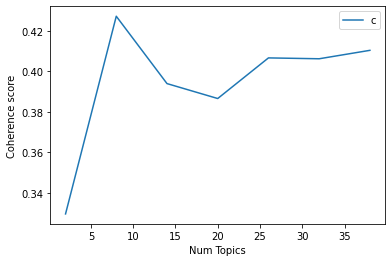

In [117]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [118]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3297
Num Topics = 8  has Coherence Value of 0.4272
Num Topics = 14  has Coherence Value of 0.394
Num Topics = 20  has Coherence Value of 0.3866
Num Topics = 26  has Coherence Value of 0.4066
Num Topics = 32  has Coherence Value of 0.4062
Num Topics = 38  has Coherence Value of 0.4104


In [119]:
optimal_model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=8, id2word=id2word)

In [120]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

c:\Users\yarem\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.092439 -0.069346       1        1  20.820870
4      0.094965  0.168268       2        1  20.758235
7      0.118580  0.040265       3        1  18.541660
0      0.062138 -0.057530       4        1  12.343182
2      0.073385 -0.092670       5        1  10.777017
6      0.071437 -0.092229       6        1   9.592892
5     -0.136680  0.173076       7        1   4.242613
1     -0.376263 -0.069834       8        1   2.923531, topic_info=          Term         Freq        Total Category  logprob  loglift
5144    вкусно  3016.000000  3016.000000  Default  30.0000  30.0000
2249   позитив  6278.000000  6278.000000  Default  29.0000  29.0000
8859      офис  3626.000000  3626.000000  Default  28.0000  28.0000
15643     омск  2614.000000  2614.000000  Default  27.0000  27.0000
3      уходить  6001.000000  6001.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1668     рынок    12.922666    95.112834   Topic8  -6.8372   1.5363
5418    аромат    11.557286    77.254503   Topic8  -6.9489   1.6326
8859      офис    24.014634  3626.010751   Topic8  -6.2175  -1.4848
6521    полныи     8.827280    35.128850   Topic8  -7.2183   2.1512
7819      вкус     9.321706   116.398309   Topic8  -7.1638   1.0077

[566 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
287       1  0.095094        _
287       2  0.005283        _
287       3  0.001057        _
287       4  0.754416        _
287       5  0.033811        _
...     ...       ...      ...
1591      3  0.008059   эффект
1591      5  0.024177   эффект
6691      2  0.985123     юлия
3023      5  0.979963     яицо
851       6  0.961599  ярослав

[1717 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 8, 1, 3, 7, 6, 2])

In [121]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# Show
df_dominant_topic.head(10)

C:\Users\yarem\AppData\Local\Temp\ipykernel_17196\2965365211.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\yarem\AppData\Local\Temp\ipykernel_17196\2965365211.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4,0.5695,"позитив, уходить, офис, ребенок, мужчина, люде...","когда-то было именно так , как не хочется чтоб..."
1,1,6,0.4613,"хороший, осень, тесто, лето, друг, иисус, праз...","Настюха , это похоже ты в детстве ))))))))))))..."
2,2,3,0.8546,"кожа, loc, крем, средство, тело, amp, косметик...",1 класс Математика 1нед Решение задач в два де...
3,3,4,0.3874,"позитив, уходить, офис, ребенок, мужчина, люде...",РУССКИЙ АЛФАВИТ ИЛИ АЗБУКА УРОК РУССКОГО ЯЗЫКА...
4,4,0,0.8749,"https, com, id, amp, vk, _, ru, http, mid, искать",Спасать свои автомобили от огня пришлось жител...
5,5,7,0.9131,"любить, день, любовь, рождение, человек, пусть...","Сына, ждем домой!С Днем варенья тебя!Приезжай ..."
6,6,4,0.9026,"позитив, уходить, офис, ребенок, мужчина, люде...","45-лет 20 назад мне казалось, что это так мног..."
7,7,0,0.7791,"https, com, id, amp, vk, _, ru, http, mid, искать","Звоните в ""Круиз"" Грузоперевозка у нас : НАШИ ..."
8,8,6,0.5855,"хороший, осень, тесто, лето, друг, иисус, праз...",30.07.2016 г. Выборг Всероссийская выставка со...
9,9,2,0.6373,"размер, цена, месяц, писать, масло, качество, ...","г. Москва, Помет от известнейших Интерчемпионо..."


In [122]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,4,"позитив, уходить, офис, ребенок, мужчина, люде...",2654.0,0.1327
1,6,"хороший, осень, тесто, лето, друг, иисус, праз...",605.0,0.0302
2,3,"кожа, loc, крем, средство, тело, amp, косметик...",2417.0,0.1208
3,4,"позитив, уходить, офис, ребенок, мужчина, люде...",3006.0,0.1503
4,0,"https, com, id, amp, vk, _, ru, http, mid, искать",3337.0,0.1668
...,...,...,...,...
19996,2,"размер, цена, месяц, писать, масло, качество, ...",NaN,NaN
19997,1,"омск, суперпохудение, сетевоиэтомое, nleva, en...",NaN,NaN
19998,3,"кожа, loc, крем, средство, тело, amp, косметик...",NaN,NaN
19999,3,"кожа, loc, крем, средство, тело, amp, косметик...",NaN,NaN


In [123]:
for i, j in zip(df_dominant_topics['Topic_Keywords'][:14], df_dominant_topics['Num_Documents']):
    print(i)

позитив, уходить, офис, ребенок, мужчина, людей, женщина, каждый, новый, любовь
хороший, осень, тесто, лето, друг, иисус, праздник, команда, конкурс, солнечный
кожа, loc, крем, средство, тело, amp, косметика, ru, магазин, лицо
позитив, уходить, офис, ребенок, мужчина, людей, женщина, каждый, новый, любовь
https, com, id, amp, vk, _, ru, http, mid, искать
любить, день, любовь, рождение, человек, пусть, друг, девочка, мама, здоровье
позитив, уходить, офис, ребенок, мужчина, людей, женщина, каждый, новый, любовь
https, com, id, amp, vk, _, ru, http, mid, искать
хороший, осень, тесто, лето, друг, иисус, праздник, команда, конкурс, солнечный
размер, цена, месяц, писать, масло, качество, см, заказ, цвет, приглашать
кожа, loc, крем, средство, тело, amp, косметика, ru, магазин, лицо
вкусно, офис, адреналин, уходить, energydiet, nleva, суперпохудение, сетевоиэтомое, пополнение, друг
хороший, осень, тесто, лето, друг, иисус, праздник, команда, конкурс, солнечный
хороший, осень, тесто, лето, друг

In [74]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,7,"id, привет, блин, хотеть, приветик, сегодня, т...",1778.0,0.0889
1,10,"xd, писать, ето, встречаться, наш, первый, сук...",746.0,0.0373
2,12,"любить, _, мой, ты, очень, спасибо, это, быть,...",624.0,0.0312
3,11,"знать, это, помнить, сказать, ахи, завтра, моч...",750.0,0.0375
4,5,"пойти, написать, супер, приезжать, оч, почему,...",607.0,0.0304
...,...,...,...,...
19995,8,"это, человек, понимать, свой, сделать, глаз, т...",NaN,NaN
19996,0,"думать, такой, тело, любить, утро, фильм, сост...",NaN,NaN
19997,12,"любить, _, мой, ты, очень, спасибо, это, быть,...",NaN,NaN
19998,12,"любить, _, мой, ты, очень, спасибо, это, быть,...",NaN,NaN


In [9]:
def lemmatize_sents(sents):
    for sent in sents:
        yield [i for i in stem.lemmatize(sent) if not (re.match(r'[^\w\s]', i) is not None or i ==' ' or i =='\n') ]

In [10]:
dataset_short_lemmatized = list(lemmatize_sents(dataset_short['text']))

In [12]:
cv = CountVectorizer(max_features=1000, stop_words=ru_stopwords)
n_wd = np.array(cv.fit_transform(list(dataset['text'])[:500_000]).todense()).T
vocabulary = cv.get_feature_names_out ()

c:\Users\yarem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [29]:
# bv = artm.BatchVectorizer(data_format='bow_n_wd',
#                           n_wd=n_wd,
#                           vocabulary=vocabulary)

In [36]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

'þты'

In [6]:
import yaml
with open('topics_20000_45_1.yaml','r') as f:
    l_45_1 = yaml.safe_load(f)
with open('topics_20000.yaml','r') as f:
    l_17_1 = yaml.safe_load(f)

In [9]:
l_45_1

{0: '0.026*"омск" + 0.013*"любить" + 0.010*"ребенок" + 0.008*"женщина" + 0.007*"компания" + 0.007*"месяц" + 0.007*"хороший" + 0.007*"друг" + 0.007*"каждый" + 0.007*"новый"',
 1: '0.030*"вкусно" + 0.024*"позитив" + 0.014*"адреналин" + 0.008*"nleva" + 0.008*"сетевоиэтомое" + 0.008*"глаз" + 0.007*"суперпохудение" + 0.007*"быстро" + 0.007*"energydiet" + 0.007*"лицо"',
 2: '0.019*"офис" + 0.018*"уходить" + 0.013*"_" + 0.009*"com" + 0.009*"сеичас" + 0.008*"ru" + 0.008*"цена" + 0.008*"косметика" + 0.008*"id" + 0.008*"vk"',
 3: '0.010*"человек" + 0.009*"amp" + 0.009*"кожа" + 0.009*"средство" + 0.007*"крем" + 0.007*"качество" + 0.007*"своеи" + 0.006*"тело" + 0.006*"результат" + 0.005*"начинать"',
 4: '0.010*"украина" + 0.007*"новосибирск" + 0.006*"страна" + 0.006*"бизнес" + 0.006*"начинаться" + 0.005*"солнце" + 0.005*"земля" + 0.005*"год" + 0.004*"идти" + 0.004*"слово"'}

In [10]:
for i in l_17_1:
    print(f'{i}: {l_17_1[i]}')

0: 0.095*"мир" + 0.088*"мы" + 0.062*"надеяться" + 0.060*"место" + 0.041*"видео" + 0.040*"часто" + 0.024*"весело" + 0.021*"прекрасныи" + 0.013*"роль" + 0.004*"сыграть"
1: 0.400*"хотеть" + 0.097*"жить" + 0.024*"ребенок" + 0.013*"папа" + 0.009*"похожий" + 0.006*"красиво" + 0.006*"легкий" + 0.004*"внутри" + 0.000*"который" + 0.000*"тобой"
2: 0.192*"понимать" + 0.089*"никто" + 0.084*"нужный" + 0.026*"март" + 0.024*"кроме" + 0.006*"кровь" + 0.000*"который" + 0.000*"ходить" + 0.000*"комната" + 0.000*"начинать"
3: 0.067*"вернуть" + 0.055*"домои" + 0.030*"вода" + 0.023*"забирать" + 0.021*"детея" + 0.016*"ухо" + 0.014*"пиздец" + 0.009*"женя" + 0.004*"ржать" + 0.000*"русалка"
4: 0.209*"знать" + 0.162*"твой" + 0.052*"слово" + 0.052*"рядом" + 0.048*"девочка" + 0.048*"лишь" + 0.031*"улыбка" + 0.020*"история" + 0.018*"чужой" + 0.010*"взгляд"
5: 0.335*"_" + 0.071*"самый" + 0.061*"хороший" + 0.040*"один" + 0.033*"спать" + 0.028*"скоро" + 0.027*"ночь" + 0.022*"оставаться" + 0.022*"вместе" + 0.020*"самыя